<a href="https://colab.research.google.com/github/VictoorV/Breast_cancer/blob/main/Projet_cancer_du_sein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path1 = kagglehub.dataset_download("hayder17/breast-cancer-detection")

print("Path to dataset files:", path1)

# Download latest version
path2 = kagglehub.dataset_download("victorvannobel/bc-additional-positive")

print("Path to dataset files:", path2)

100%|██████████| 87.2M/87.2M [00:01<00:00, 50.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hayder17/breast-cancer-detection/versions/1


100%|██████████| 269M/269M [00:06<00:00, 43.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/victorvannobel/bc-additional-positive/versions/1


In [2]:
import os
os.chdir('/root/.cache/kagglehub/datasets/victorvannobel/bc-additional-positive/versions/1/train_image_processed_dicoml_DDSM_PNG/')
files = os.listdir()
for i, file in enumerate(files):
    if i % 2 == 0:  # Supprime les fichiers avec un indice pair
        os.remove(file)  # Supprime le fichier

In [3]:
!cp -r /root/.cache/kagglehub/datasets/hayder17/breast-cancer-detection/versions/1 /content/breast-cancer-detection

In [ ]:
!cp -r /root/.cache/kagglehub/datasets/victorvannobel/bc-additional-positive/versions/1/train_image_processed_dicoml_DDSM_PNG/* /content/breast-cancer-detection/train/1

In [4]:
directory = '/content'
print("Ancien répertoire :", directory)
os.chdir(directory+'/breast-cancer-detection')
current_directory = os.getcwd()
print("Nouveau répertoire :", current_directory)

Ancien répertoire : /content
Nouveau répertoire : /content/breast-cancer-detection


In [5]:
pip install torchinfo

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets
from PIL import Image
import torchvision.transforms as T
import torch
from torch import nn, optim
from torchvision import models
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
im_size = 640

transform_train = transforms.Compose([
    transforms.Resize((im_size, im_size)),  # Redimensionner les images
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.35, scale=(0.05, 0.15), ratio=(0.5, 1), value=0),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Charger les images depuis le dossier
train_dataset = datasets.ImageFolder(
    root="/content/breast-cancer-detection/train",
    transform=transform_train
)

valid_dataset = datasets.ImageFolder(
    root="/content/breast-cancer-detection/valid",
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root="/content/breast-cancer-detection/test",
    transform=transform
)

In [8]:
path_0 = "/content/breast-cancer-detection/train/0"
path_1 = "/content/breast-cancer-detection/train/1"

num_images_0 = len(os.listdir(path_0))
num_images_1 = len(os.listdir(path_1))

print(f"Nombre d'images dans le dossier 0 : {num_images_0}")
print(f"Nombre d'images dans le dossier 1 : {num_images_1}")

Nombre d'images dans le dossier 0 : 1569
Nombre d'images dans le dossier 1 : 803


In [9]:
batch_size = 80
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Classes: ['0', '1']
Shape des images: torch.Size([4, 3, 640, 640])


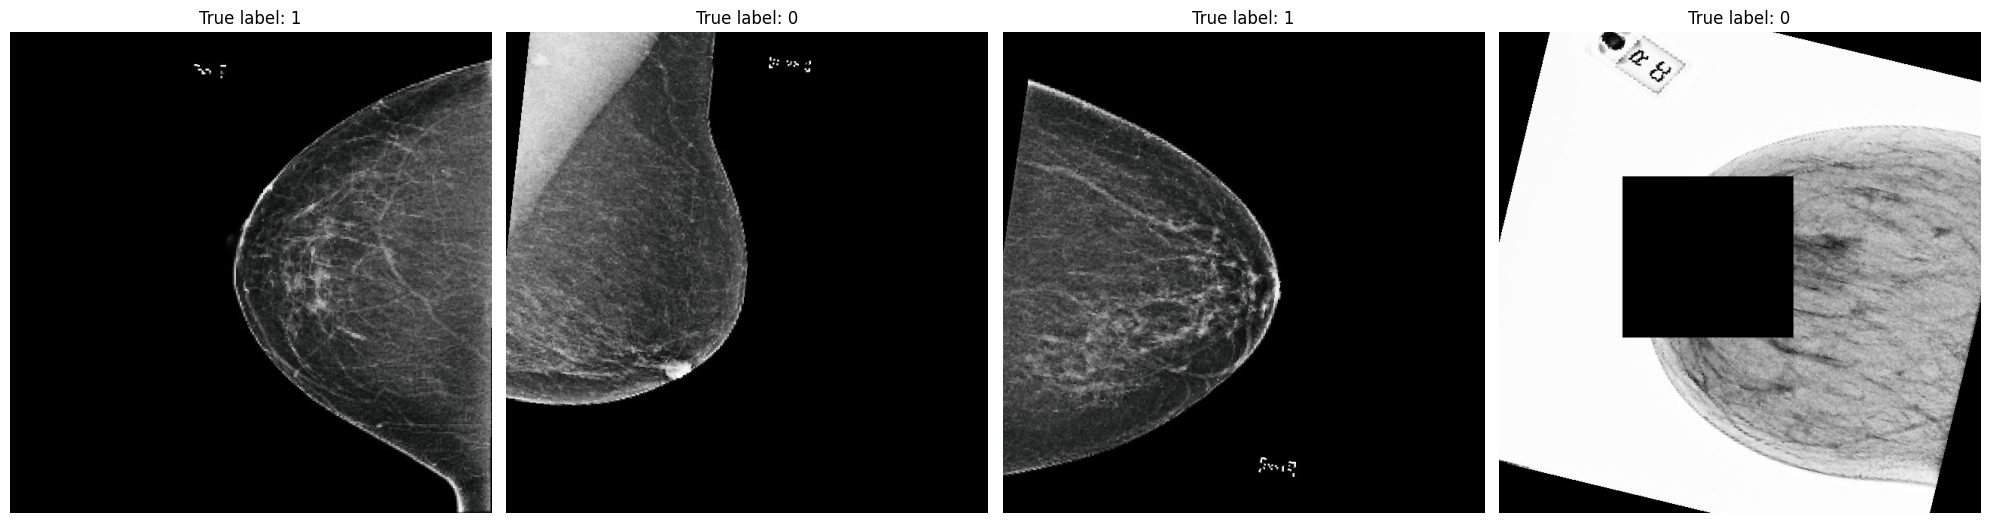

In [10]:
# Aperçu des classes
class_names = train_dataset.classes
print("Classes:", class_names)

torch.manual_seed(0)
for images, labels in train_loader:
    images = images[0:4]  # Prendre les 4 premières images
    labels = labels[0:4]  # Prendre les 4 premières étiquettes
    print("Shape des images:", images.shape)  # Vérification de la forme des tenseurs

    # Inverser la normalisation
    inv_transform = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1/0.229, 1/0.224, 1/0.225])

    unnormalized_images = torch.stack([inv_transform(img) for img in images])

    # Convertir en images PIL
    to_pil = transforms.ToPILImage()

    # Affichage
    fig, ax = plt.subplots(1, 4, figsize=(20, 20))
    for i in range(4):
        ax[i].imshow(to_pil(unnormalized_images[i]))
        ax[i].set_title(f"True label: {class_names[labels[i].item()]}")
        ax[i].axis("off")
    plt.tight_layout()
    plt.show()
    break


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
pip install torch torchvision timm

In [12]:
#model = models.resnet50(pretrained=True)
model = models.convnext_tiny(pretrained=True)  # convnext_tiny   convnext_small   convnext_base

#from timm import create_model

# Charger le modèle EfficientNetV2 Small pré-entraîné
#model = create_model("efficientnetv2_s", pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 98.6MB/s]


In [ ]:
print(model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [13]:
# ConvNeXt
model.classifier[2] = nn.Linear(768,2)

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

for param in model.features[-1].parameters():
    param.requires_grad = True


In [ ]:
# ResNet
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 1024),
    nn.LeakyReLU(negative_slope=0.001),
    nn.Linear(1024,2)
  )
model.fc

for param in model.parameters():
    param.requires_grad = False

"""for param in model.layer3.parameters():
    param.requires_grad = True"""

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): LeakyReLU(negative_slope=0.001)
  (3): Linear(in_features=1024, out_features=2, bias=True)
)

In [29]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable")
    else:
        print(f"{name} is frozen")

features.0.0.weight is frozen
features.0.0.bias is frozen
features.0.1.weight is frozen
features.0.1.bias is frozen
features.1.0.layer_scale is frozen
features.1.0.block.0.weight is frozen
features.1.0.block.0.bias is frozen
features.1.0.block.2.weight is frozen
features.1.0.block.2.bias is frozen
features.1.0.block.3.weight is frozen
features.1.0.block.3.bias is frozen
features.1.0.block.5.weight is frozen
features.1.0.block.5.bias is frozen
features.1.1.layer_scale is frozen
features.1.1.block.0.weight is frozen
features.1.1.block.0.bias is frozen
features.1.1.block.2.weight is frozen
features.1.1.block.2.bias is frozen
features.1.1.block.3.weight is frozen
features.1.1.block.3.bias is frozen
features.1.1.block.5.weight is frozen
features.1.1.block.5.bias is frozen
features.1.2.layer_scale is frozen
features.1.2.block.0.weight is frozen
features.1.2.block.0.bias is frozen
features.1.2.block.2.weight is frozen
features.1.2.block.2.bias is frozen
features.1.2.block.3.weight is frozen
f

In [28]:
summary(model, input_size=(1, 3, im_size, im_size))

Layer (type:depth-idx)                        Output Shape              Param #
ConvNeXt                                      [1, 2]                    --
├─Sequential: 1-1                             [1, 768, 20, 20]          --
│    └─Conv2dNormActivation: 2-1              [1, 96, 160, 160]         --
│    │    └─Conv2d: 3-1                       [1, 96, 160, 160]         (4,704)
│    │    └─LayerNorm2d: 3-2                  [1, 96, 160, 160]         (192)
│    └─Sequential: 2-2                        [1, 96, 160, 160]         --
│    │    └─CNBlock: 3-3                      [1, 96, 160, 160]         (79,296)
│    │    └─CNBlock: 3-4                      [1, 96, 160, 160]         (79,296)
│    │    └─CNBlock: 3-5                      [1, 96, 160, 160]         (79,296)
│    └─Sequential: 2-3                        [1, 192, 80, 80]          --
│    │    └─LayerNorm2d: 3-6                  [1, 96, 160, 160]         (192)
│    │    └─Conv2d: 3-7                       [1, 192, 80, 80]    

# Train, evaluation functions

In [14]:
def train(model, loader, historical_loss, historical_acc):
  model.train()
  train_loss = 0.0
  correct = 0
  total = 0
  for images, labels in loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()

    train_loss+=loss.item()
  train_loss = train_loss/len(loader)
  train_acc = 100 * correct/total
  historical_loss.append(train_loss)
  historical_acc.append(train_acc)

In [15]:
def evaluation(model, loader, historical_loss, historical_acc):
  model.eval()
  eval_loss = 0.0
  correct = 0
  total = 0
  for images, labels in loader:
    with torch.no_grad():
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      _, preds = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (preds == labels).sum().item()

      eval_loss+=loss.item()
  eval_loss = eval_loss/len(loader)
  eval_acc = 100 * correct/total
  historical_loss.append(eval_loss)
  historical_acc.append(eval_acc)

# Training loop

In [16]:
model = model.to(device)

In [17]:
#params_to_update =list(model.fc.parameters()) + list(model.layer4.parameters())
params_to_update = list(model.classifier.parameters())+list(model.features[-1].parameters())

class_weights = torch.tensor([1., 1.5]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
#optimizer = optim.SGD(params_to_update, lr=1e-3, momentum=0.9, weight_decay=1e-4)
optimizer = optim.AdamW(params_to_update, lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

epochs = 20
training_loss = []
validation_loss = []
training_acc = []
validation_acc = []

In [18]:
for epoch in range(epochs):
  current_lr = scheduler.get_last_lr()[0]
  train(model, train_loader, training_loss, training_acc)
  evaluation(model, valid_loader, validation_loss, validation_acc)
  print(f"Epoch [{epoch+1}/{epochs}], Current LR: {current_lr:.6f}, Training Loss: {training_loss[-1]:.4f}, Training Acc: {training_acc[-1]:.4f}, Validation Loss: {validation_loss[-1]:.4f}, Validation Acc: {validation_acc[-1]:.4f}")
  scheduler.step()

  model_name =  str(epoch+1) + "_" + model.__class__.__name__+".pth"
  torch.save(model.state_dict(), model_name)
  print(f"Saving {model_name}")

Epoch [1/20], Current LR: 0.001000, Training Loss: 0.7825, Training Acc: 59.9494, Validation Loss: 0.6792, Validation Acc: 54.5185
Saving 1_ConvNeXt.pth
Epoch [2/20], Current LR: 0.000994, Training Loss: 0.6673, Training Acc: 64.2496, Validation Loss: 0.6628, Validation Acc: 66.5185
Saving 2_ConvNeXt.pth
Epoch [3/20], Current LR: 0.000976, Training Loss: 0.6512, Training Acc: 64.4182, Validation Loss: 0.6442, Validation Acc: 66.2222
Saving 3_ConvNeXt.pth
Epoch [4/20], Current LR: 0.000946, Training Loss: 0.6539, Training Acc: 64.4182, Validation Loss: 0.6461, Validation Acc: 64.8889
Saving 4_ConvNeXt.pth
Epoch [5/20], Current LR: 0.000905, Training Loss: 0.6310, Training Acc: 67.8331, Validation Loss: 0.6547, Validation Acc: 56.4444
Saving 5_ConvNeXt.pth
Epoch [6/20], Current LR: 0.000855, Training Loss: 0.6302, Training Acc: 66.3575, Validation Loss: 0.6409, Validation Acc: 69.6296
Saving 6_ConvNeXt.pth
Epoch [7/20], Current LR: 0.000796, Training Loss: 0.6073, Training Acc: 68.6341, 

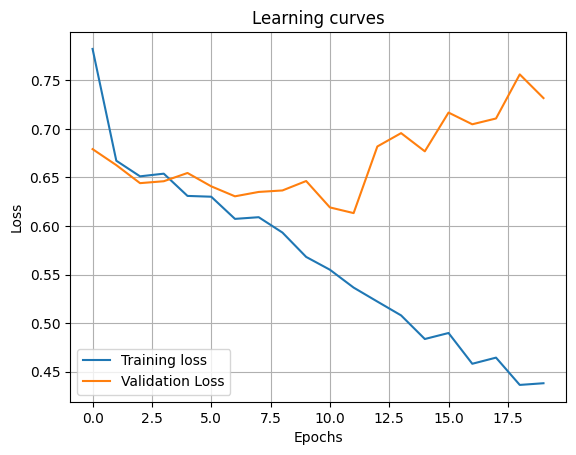

In [19]:
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Learning curves")
plt.grid()
plt.legend()
plt.show()

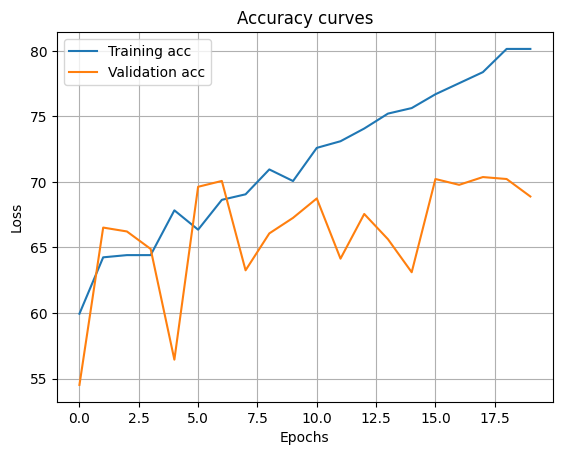

In [20]:
plt.plot(training_acc, label='Training acc')
plt.plot(validation_acc, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Accuracy curves")
plt.grid()
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('20_ConvNeXt.pth'))

<ipython-input-34-9f5fb4e02a6b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('20_ConvNeXt.pth'))


<All keys matched successfully>

In [26]:
weights_to_save = {
    "classifier": model.classifier.state_dict(),
    "features_last_layer": model.features[-1].state_dict(),
}

torch.save(weights_to_save, "selected_weights.pth")

print("Modèle sauvegardé sur Colab.")

Modèle sauvegardé sur Colab.


In [27]:
from google.colab import files

files.download('selected_weights.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
weights = torch.load("./selected_weights.pth")

<ipython-input-20-b662db285d32>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("./selected_weights.pth")


In [ ]:
model.features[-1].load_state_dict(weights["features_last_layer"])
model.classifier.load_state_dict(weights["classifier"])

<All keys matched successfully>

# Résultats

In [21]:
from sklearn.metrics import classification_report
label_true = []
label_pred = []
probas_list_class_1 = []

images_list = []  # Pour stocker les images à afficher
torch.manual_seed(2024)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pred_lab = torch.max(outputs, dim=1)
        probas_class_1 = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

        probas_list_class_1.extend(probas_class_1)
        label_true.extend(labels.cpu().numpy())
        label_pred.extend(pred_lab.cpu().numpy())

        images_list.extend(images.cpu().numpy())

In [22]:
print(classification_report(label_true, label_pred))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       208
           1       0.61      0.66      0.64       128

    accuracy                           0.71       336
   macro avg       0.70      0.70      0.70       336
weighted avg       0.72      0.71      0.71       336



<Axes: >

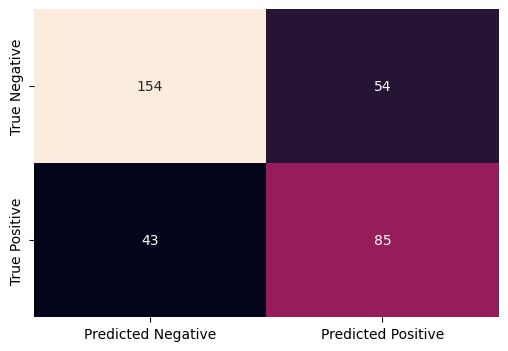

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label_true, label_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])

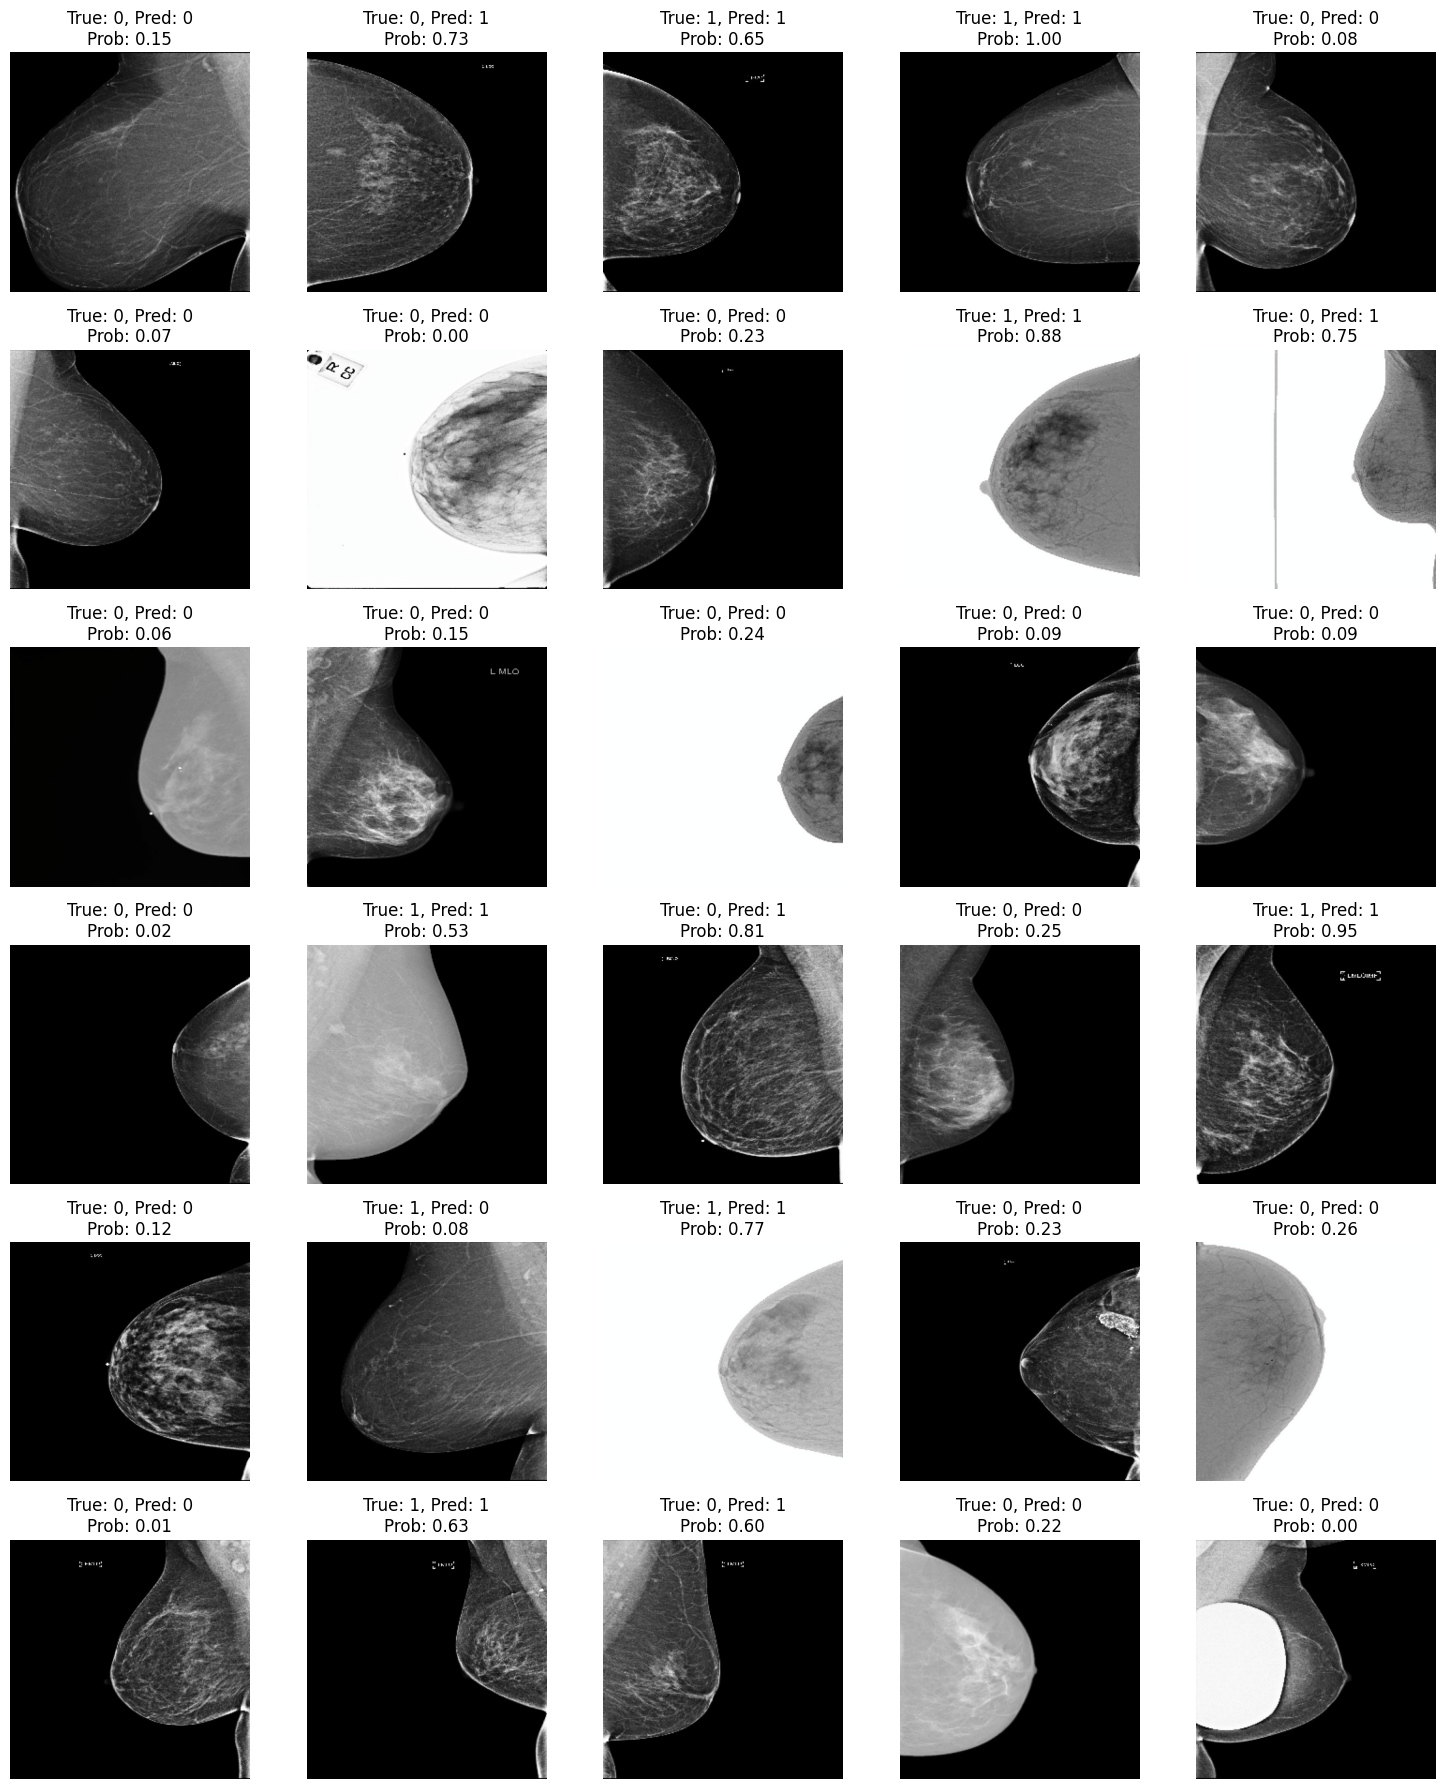

In [24]:
import numpy as np

def denormalize(tensor, mean, std):
    """
    Inverse la normalisation des images.
    Attend un tenseur au format (C, H, W).
    """
    mean = np.array(mean).reshape(3, 1, 1)  # Reshape pour correspondre à (C, 1, 1)
    std = np.array(std).reshape(3, 1, 1)    # Reshape pour correspondre à (C, 1, 1)
    tensor = std * tensor + mean            # Dénormalisation

    tensor = tensor.transpose((1, 2, 0))    # Retour au format (H, W, C) pour Matplotlib
    return np.clip(tensor, 0, 1)

def show_images_with_predictions(images_list, labels_true, labels_pred, probas, mean, std, num_images=30):
    """
    Affiche des images avec les étiquettes vraies, les prédictions et les probabilités.

    Args:
    - images_list: Liste des images au format (C, H, W).
    - labels_true: Liste des étiquettes vraies.
    - labels_pred: Liste des étiquettes prédites.
    - probas: Liste des probabilités pour la classe 1.
    - mean: Moyenne utilisée pour la normalisation des images.
    - std: Écart-type utilisé pour la normalisation des images.
    - num_images: Nombre d'images à afficher (par défaut 30).
    """
    num_images = min(num_images, len(images_list))  # Limiter à la taille de la liste
    rows = (num_images + 4) // 5  # Nombre de lignes (5 images par ligne)
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))

    for i in range(num_images):
        img = images_list[i]
        true_label = labels_true[i]
        pred_label = labels_pred[i]
        proba = probas[i]

        # Dénormaliser l'image
        denormalized_img = denormalize(img, mean, std)

        ax = axes[i // 5, i % 5] if rows > 1 else axes[i % 5]  # Accès à l'axe correspondant
        ax.imshow(denormalized_img)
        ax.axis('off')
        ax.set_title(f"True: {true_label}, Pred: {pred_label}\nProb: {proba:.2f}")

    # Supprimer les axes inutilisés
    for j in range(num_images, rows * 5):
        ax = axes[j // 5, j % 5] if rows > 1 else axes[j % 5]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_images_with_predictions(
    images_list=images_list[:30],
    labels_true=label_true[:30],
    labels_pred=label_pred[:30],
    probas=probas_list_class_1[:30],
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    num_images=30)